In [4]:
import math
import torch
import torch.nn as nn

if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
device = torch.device(dev)

def get_generators(k: int, l: int, m: int, D: int=50) -> list[torch.nn.Module]:
    return [build_generator(l, m, D) for _ in range(k)]


@torch.no_grad()
def get_regression_targets(n:int, k: int, l: int, generators: list[torch.nn.Module], sample_mode: str='random', correlation: float=0, delta: float=0) -> tuple[torch.Tensor, torch.Tensor]:
    if sample_mode == 'random':
        z = torch.rand(n, k, l)
    elif sample_mode == 'diagonal':
        _n = 10*n
        z = torch.Tensor(0, k, l)
        while z.shape[0] < n:
            # sample randomly on diagonal
            _z = torch.repeat_interleave(torch.rand(n, l), k, dim=0).reshape(n, k, l)
            # apply random offset
            _z += torch.rand(n, k, l) * 2 * delta - delta
            # reject samples outside the domain
            mask = ~((_z - 0.5).abs() > 0.5).flatten(1).any(1)
            idx = mask.nonzero().squeeze()
            z = torch.cat([z, _z[idx]])
        z = z[:n]
    elif sample_mode == 'pure_off_diagonal':
        _n = 10*n
        z = torch.Tensor(0, k, l)
        while z.shape[0] < n:
            # sample randomly in whole space
            _z = torch.rand(_n, k, l)  
            # compute distances between blocks
            triuidx = torch.triu_indices(k, k)  
            mutual_distances = (_z.unsqueeze(1).repeat(1, _z.shape[1], 1, 1) - _z.unsqueeze(1).repeat(1, _z.shape[1], 1, 1).transpose(1, 2))[:, triuidx[0], triuidx[1], :]
            # reject samples on diagonal
            mask = (mutual_distances.abs() > 2*delta).any(dim=1).all(dim=1)
            idx = mask.nonzero().squeeze()
            z = torch.cat([z, _z[idx]])
        z = z[:n]
    elif sample_mode == 'off_diagonal':
        _n = 10*n
        z = torch.Tensor(0, k, l)
        while z.shape[0] < n:
            # sample randomly in whole space
            _z = torch.rand(_n, k, l)  
            # compute distances between blocks
            triuidx = torch.triu_indices(k, k)  
            mutual_distances = (_z.unsqueeze(1).repeat(1, _z.shape[1], 1, 1) - _z.unsqueeze(1).repeat(1, _z.shape[1], 1, 1).transpose(1, 2))[:, triuidx[0], triuidx[1], :]
            # reject samples on diagonal
            mask = (mutual_distances.abs() > 2*delta).any(dim=1).any(dim=1)
            idx = mask.nonzero().squeeze()
            z = torch.cat([z, _z[idx]])
        z = z[:n]
    elif sample_mode == 'orthogonal':
        _z = torch.rand(n, l)
        mask = torch.stack([torch.arange(n), torch.randint(k, (n, 1)).squeeze(dim=1)], dim=1).long()
        z = torch.zeros(n, k, l)
        z[mask.chunk(chunks=2, dim=1)] = _z.unsqueeze(1)
    elif sample_mode == 'mix':
        n_diag = int(n * correlation,)
        _z_diag = torch.repeat_interleave(torch.rand(n_diag, l), k, dim=0).reshape(n_diag, k, l)
        _z_rand = torch.rand(n - n_diag, k, l)
        z = torch.cat([_z_diag, _z_rand])[torch.randperm(n)]
    else:
        raise Exception(f'no sampling mode {sample_mode}')
    
    x = [torch.stack([generators[j](z[i][j]) for j in range(k)]) for i in range(n)]
    x = torch.stack(x)

    return z, x

def build_generator(l: int, m: int, D: int, slope: float=0.2) -> nn.Sequential:
    g = nn.Sequential(
        nn.Linear(l, D),
        nn.LeakyReLU(slope),
        nn.Linear(D, m),
        nn.LeakyReLU(slope)
    )
    g.apply(init_min_cond)
    return g


def init_min_cond(m: torch.nn.Module, n_samples: int=7500) -> torch.Tensor:
    if isinstance(m, nn.Linear):
        w = m.weight.data
        k = 1 / w.size(0)

        w = torch.nn.functional.normalize(w, p=2)
        cond = condition_number(w)

        for _ in range(n_samples):
            _w = 2 * math.sqrt(k) * torch.rand(w.size()) - math.sqrt(k)
            _w = nn.functional.normalize(_w, p=2)
            _cond = condition_number(_w)

            if _cond < cond:
                w = _w
                cond = _cond
        
        m.weight.data = w


def condition_number(t: torch.Tensor) -> float:
    return torch.norm(t, p=2) / torch.norm(torch.pinverse(t), p=2)


In [5]:
def build_MLP(d_in: int, d_out: int, D: int=120, slope: float=0.2, **kwargs) -> nn.Sequential:
    return nn.Sequential(
        nn.Linear(d_in, D),
        nn.LeakyReLU(slope),
        nn.Linear(D, d_out),
        nn.LeakyReLU(slope)
    )


def MLP(k: int, l: int, m: int, D: int=120, **kwargs):
    return build_MLP(k * m, k * l, D, **kwargs)


def MLPTanh(k: int, l: int, m: int, D: int=120, **kwargs):
    return nn.Sequential(
        nn.Linear(k * m, D),
        nn.Tanh(),
        nn.Linear(D, k * l),
        nn.Tanh()
    )


class CompositionalMLP(torch.nn.Module):
    def __init__(self, k: int, l: int, m: int, D: int=120, **kwargs):
        super(CompositionalMLP, self).__init__()
        self.k = k
        self.models = nn.ModuleList([build_MLP(k * m, l, round(D / k), **kwargs) for _ in range(k)])
    
    def forward(self, x):
        x = x.reshape(x.size(0), self.k, -1)
        out = []
        for i in range(len(self.models)):
            x_i = torch.zeros_like(x)
            x_i[:, i, :] = x[:, i, :]
            x_i = torch.flatten(x_i, start_dim = 1)
            out.append(self.models[i](x_i))
        return torch.cat(out, dim=1)


class Autoencoder(torch.nn.Module):
    def __init__(self, k: int, l: int, m: int, D: int=120, **kwargs):
        super(Autoencoder, self).__init__()
        self.f = build_MLP(k * m, k * l, D, **kwargs)
        self.g = build_MLP(k * l, k * m, D, **kwargs)
    
    def forward(self, x):
        z = self.f(x)
        out = self.g(z)
        return out, z

In [6]:
from curses import KEY_SAVE
from dataclasses import dataclass
from unittest import FunctionTestCase
import torch
import torch.nn as nn
import torch.optim as optim
import functorch
from torchmetrics import R2Score
from tqdm import tqdm
import dataclasses

# could be more efficient with torch.utils.data.TensorDataset, but I couldn't be assed to look up the documentation
class Dataset(torch.utils.data.Dataset):
    def __init__(self, n: int, k: int, l: int, generators: list[torch.nn.Module], **sample_kwargs):
        super(Dataset, self).__init__()
        self.n = n
        self.z, self.x = get_regression_targets(n, k, l, generators, **sample_kwargs)
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return self.x[idx], self.z[idx]


class OODDataset(Dataset):
    def __init__(self, n: int, k: int, l: int, generators: list[torch.nn.Module], **sample_kwargs):
        super(Dataset, self).__init__()
        self.n = n
        if sample_kwargs['sample_mode'] == 'diagonal':
            sample_kwargs['sample_mode'] = 'off_diagonal'
        else:
            raise NotImplementedError
        self.z, self.x = get_regression_targets(n, k, l, generators, **sample_kwargs)


class GenerativeDataloader:
    def __init__(self, bs:int, k: int, l: int, generators: list[torch.nn.Module], n: int=1, **sample_kwargs):
        self.k = k
        self.l = l
        self.generators = generators
        self.bs = bs
        self.sample_kwargs = sample_kwargs
        self.len = n
        self.current = -1
    
    def __iter__(self):
        return self

    def __next__(self):
        self.current += 1
        if self.current < self.len:
            z, x = get_regression_targets(self.bs, self.k, self.l, self.generators, **self.sample_kwargs)
            return x, z
        self.current = -1
        raise StopIteration


class Regularizer:
    def __init__(self, function: torch.nn.Module, weight: float=1, **kwargs):
        self.function = function
        self.weight = weight
        self.kwargs = kwargs

    def __call__(self, model, x):
        return self.weight * self.function(model, x, **self.kwargs)


def train(model: torch.nn.Module, trainloader: torch.utils.data.DataLoader, lr: float=0.001, epochs: int=10):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # for epoch in tqdm(range(epochs)):
    for epoch in range(epochs):
        cum_loss = 0

        for batch, data in enumerate(trainloader, 0):
            x, z = data

            optimizer.zero_grad()

            out = model(torch.flatten(x, start_dim=1))
            loss = criterion(out, torch.flatten(z, start_dim=1))
            cum_loss += loss
            loss.backward()
            optimizer.step()
        
        cum_loss /= (batch + 1)
    
    return cum_loss


# train for the same number of iterations (batches) independent of dataset size (i.e. without epochs)
def train_iter(model: torch.nn.Module, trainloader: torch.utils.data.DataLoader, lr: float=0.001, criterion: torch.nn.Module=nn.MSELoss, regularizer: Regularizer=None):
    criterion = criterion()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    cum_loss = 0

    for batch, data in enumerate(trainloader, 0):
        x, z = data

        optimizer.zero_grad()

        x.requires_grad = True
        x = x.flatten(1).to(dev)
        z = z.flatten(1).to(dev)

        z_hat = model(x)
        loss = criterion(z_hat, z)
        if regularizer is not None:
            loss += regularizer(model, x)
        cum_loss += loss
        loss.backward()
        optimizer.step()
    
    cum_loss /= (batch + 1)
    return cum_loss.to(torch.device('cpu')).item()


def comp_contrast(func: torch.nn.Module, inputs: torch.Tensor, k: int=4, l: int=2, p: float=2) -> torch.Tensor:
    """Calculate the compositional contrast for a function `func` with respect to `inputs`.

    The output is calculated as the mean over the batch dimension.
    `inputs` needs to be flattened except for the batch dimension and `requires_grad` needs to be set to `True`.
    """
    assert inputs.requires_grad == True, 'To calculate the derivative by `inputs` `requires_grad` needs to be set to `True`.'
    assert p > 0

    # compute the jacobian with respect to the inputs
    jac = functorch.vmap(functorch.jacrev(func))(inputs).transpose(1, 2)

    # compute the compositional contrast as the sum of all pairs of partial derivatives for all outputs
    # average over the batch dimension
    if p == 1:
        cc = (jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1)).abs() * (jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1).transpose(2, 3)).abs()

        block_diagonal = torch.block_diag(*torch.ones(k, l, l, dtype=bool)).to(dev)
        cc = torch.where(~block_diagonal, cc, 0).triu(1).sum((1, 2, 3)).mean()
        return cc
    
    cc = (jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1)).pow(p) * (jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1).transpose(2, 3)).pow(2)

    block_diagonal = torch.block_diag(*torch.ones(k, l, l, dtype=bool)).to(dev)
    cc = torch.where(~block_diagonal, cc, 0).triu(1).sum((2, 3)).pow(1/p).sum(1).mean()
    return cc


def sparse_hess(func: torch.nn.Module, inputs: torch.Tensor, p: int=2) -> torch.Tensor:
    hess = functorch.vmap(functorch.hessian(func))(inputs)

    return torch.mean(hess.norm(dim=(1, 2, 3), p=p))


def sparse_hess2(func: torch.nn.Module, inputs: torch.Tensor) -> torch.Tensor:
    # FIXME change sum() to norm
    mask = torch.ones(8, 40, 40, dtype=torch.uint8).to(dev)
    for i in range(4):
        mask[i*2:(i+1)*2, i*10:(i+1)*10, i*10:(i+1)*10] = 0
    
    hess = functorch.vmap(functorch.hessian(func))(inputs)

    return torch.masked_select(hess, mask).sum()


# @torch.no_grad()
def test(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, metric: callable=None, **reg_kwargs):
    cum_score = 0

    for batch, data in enumerate(dataloader, 0):
        x, z = data
        x.requires_grad = True
        x = x.flatten(1).to(dev)
        z = z.flatten(1).to(dev)
        if metric is None:
            out = model(x)
            r2score = R2Score(out.size(1)).to(dev)
            score = r2score(out, z)
        else:
            score = metric(model, x, **reg_kwargs)
        cum_score += score
    
    cum_score /= (batch + 1)
    return cum_score.to(torch.device('cpu')).item()

In [5]:
# from dataclasses import dataclass, field

# @dataclass
# class Setting:
#     abbr: str
#     k: int = 4
#     l: int = 2
#     m: int = 10


# @dataclass
# class Sampling:
#     abbr: str
#     name: str
#     n: int = 4096
#     kwargs: dict = field(default_factory={'sample_mode': 'diagonal', 'delta': 0.1})


# @dataclass
# class Regularizer:
#     func: torch.nn.Module
#     weight: float = 1
#     func_args: dict = field(default_factory={})

#     def __call__(self, model, x):
#         return self.weight * self.func(model, x, **self.func_args)


# @dataclass
# class Model:
#     abbr: str
#     name: str
#     model: torch.nn.Module = MLPTanh
#     max_iter: int = 10001
#     bs: int = 4096
#     lr: float = 0.1
#     lr_steps: list[int] = []
#     regularizer: Regularizer = None

In [32]:
import os
import shutil
import datetime
import pandas as pd
import pickle as pk
from tqdm.notebook import tqdm

torch.manual_seed(0)

experiment_name = 'test_setting_genloader'

settings = [
    # {'str': 'k4l2m10', 'k': 4, 'l': 2, 'm': 10},
    {'str': 'k8l2m10', 'k': 8, 'l': 2, 'm': 10},
]

samplings = [
    # {'str': 'rand', 'name': 'random', 'n': 4096, 'kwargs': {'sample_mode': 'random'}},
    # {'str': 'orth', 'name': 'orthogonal', 'n': 4096, 'kwargs': {'sample_mode': 'orthogonal'}},
    # {'str': 'diag', 'name': 'diagonal', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.}},
    # {'str': 'diag001', 'name': 'diagonal ∆0.01', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.01}},
    # {'str': 'diag002', 'name': 'diagonal ∆0.02', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.02}},
    # {'str': 'diag005', 'name': 'diagonal ∆0.05', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.05}},
    # {'str': 'diag01', 'name': 'diagonal ∆0.1', 'n': 4096, 'bs': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.1}},
    {'str': 'diag02', 'name': 'diagonal ∆0.2', 'n': -1, 'bs': 64, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.2}},
]
# TODO move max_iter to samplings

models = [
    # {'str': 'MLP', 'name': 'MLP', 'model': MLPTanh, 'load': 'res/202208041913_i50000_lr01_bs4096/diag01_MLP.pth'},
    # {'str': 'MLPcomp', 'name': 'compositional MLP', 'model': CompositionalMLP, 'regularizer': None, },
    {'str': 'MLP01cc2', 'name': 'MLP compositional contrast λ=0.1', 'model': MLPTanh, 'max_iter': 100001, 'lr': 0.1, 'lr_steps': [], 'regularizer': {'function': comp_contrast, 'weight': 0.1, 'p': 2}},
    # {'str': 'MLP001hes2', 'name': 'MLP Hessian L2 λ=0.01', 'model': MLPTanh, 'regularizer': {'function': sparse_hess, 'weight': 0.01, 'kwargs': {'p': 2}}},
]

res = []
now = datetime.datetime.now()
res_dir = f'res/{now:%Y%m%d%H%M}_{experiment_name}'
if os.path.exists(res_dir): shutil.rmtree(res_dir)
os.mkdir(res_dir)

for setting in tqdm(settings, position=0):
    k = setting['k']
    l = setting['l']
    m = setting['m']
    # print('Build generators...')
    g = get_generators(k, l, m)
    # print('Build test data...')
    te_ds = Dataset(1000, k, l, g, sample_mode='random')
    te_ldr = torch.utils.data.DataLoader(te_ds, batch_size=1000, shuffle=True)

    for sampling in tqdm(samplings, position=1, leave=False):
        # print('Build train data...')
        n = sampling['n']
        bs = sampling['bs']
        if n == -1:
            id_ldr = GenerativeDataloader(bs, k, l, g, **sampling['kwargs'])
        else:
            id_ds = Dataset(n, k, l, g, **sampling['kwargs'])
            id_ldr = torch.utils.data.DataLoader(id_ds, batch_sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(id_ds), bs, False))
        ood_ds = OODDataset(1000, k, l, g, **sampling['kwargs'])
        ood_ldr = torch.utils.data.DataLoader(ood_ds, batch_size=1000, shuffle=True)

        for model in tqdm(models, position=2, leave=False):
            # print('Build model...')
            mdl = model['model'](k, l, m).to(dev)
            lr = model['lr']
            regularizer = Regularizer(**model['regularizer'], k=k, l=l) if 'regularizer' in model else None

            checkpoint = model.get('load', None)
            if checkpoint is not None:
                mdl.load_state_dict(torch.load(checkpoint))

            # print('Train model...')
            for i in tqdm(range(model['max_iter']), position=3, leave=False):
                if i in model['lr_steps']: lr /= 3

                loss = train_iter(mdl, id_ldr, lr=lr, regularizer=regularizer)
                res.append({'n data': n, 'n samples': (i+1)*bs, 'k': setting['k'], 'l': setting['l'], 'm': setting['m'], 'sampling': sampling['name'], 'model': model['name'], 'metric': 'train loss', 'domain': 'ID', 'val': loss})

                if i % 1000 == 0:
                    jac_id = test(mdl, id_ldr, comp_contrast, k=k, l=l)
                    jac_ood = test(mdl, ood_ldr, comp_contrast, k=k, l=l)
                    hes2_id = test(mdl, id_ldr, sparse_hess, p=2)
                    hes2_ood = test(mdl, ood_ldr, sparse_hess, p=2)

                    r2 = test(mdl, te_ldr)
                    r2_id = test(mdl, id_ldr)
                    r2_ood = test(mdl, ood_ldr)

                    res.append({'n data': n, 'n samples': (i+1)*bs, 'k': setting['k'], 'l': setting['l'], 'm': setting['m'], 'sampling': sampling['name'], 'model': model['name'], 'metric': 'compositional contrast', 'domain': 'ID', 'val': jac_id})
                    res.append({'n data': n, 'n samples': (i+1)*bs, 'k': setting['k'], 'l': setting['l'], 'm': setting['m'], 'sampling': sampling['name'], 'model': model['name'], 'metric': 'compositional contrast', 'domain': 'OOD', 'val': jac_ood})
                    res.append({'n data': n, 'n samples': (i+1)*bs, 'k': setting['k'], 'l': setting['l'], 'm': setting['m'], 'sampling': sampling['name'], 'model': model['name'], 'metric': 'sparse Hessian L2', 'domain': 'ID', 'val': hes2_id})
                    res.append({'n data': n, 'n samples': (i+1)*bs, 'k': setting['k'], 'l': setting['l'], 'm': setting['m'], 'sampling': sampling['name'], 'model': model['name'], 'metric': 'sparse Hessian L2', 'domain': 'OOD', 'val': hes2_ood})
                    res.append({'n data': n, 'n samples': (i+1)*bs, 'k': setting['k'], 'l': setting['l'], 'm': setting['m'], 'sampling': sampling['name'], 'model': model['name'], 'metric': 'test R²', 'domain': 'all', 'val': r2})
                    res.append({'n data': n, 'n samples': (i+1)*bs, 'k': setting['k'], 'l': setting['l'], 'm': setting['m'], 'sampling': sampling['name'], 'model': model['name'], 'metric': 'test R²', 'domain': 'ID', 'val': r2_id})
                    res.append({'n data': n, 'n samples': (i+1)*bs, 'k': setting['k'], 'l': setting['l'], 'm': setting['m'], 'sampling': sampling['name'], 'model': model['name'], 'metric': 'test R²', 'domain': 'OOD', 'val': r2_ood})
            
            lr_str = str(lr).replace(".", "")
            save_path = f"{res_dir}/{setting['str']}_{sampling['str']}_{model['str']}.pth"
            print(f'Save model {save_path} ...')
            torch.save(mdl.state_dict(), save_path)

        print('Save results...')
        res_df = pd.DataFrame.from_dict(res)
        with open(f'{res_dir}/df.pkl', 'wb') as f:
            pk.dump(res_df, f)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100001 [00:00<?, ?it/s]

Save model res/202208111209_test_setting_genloader/k8l2m10_diag02_MLP01cc2.pth ...
Save results...


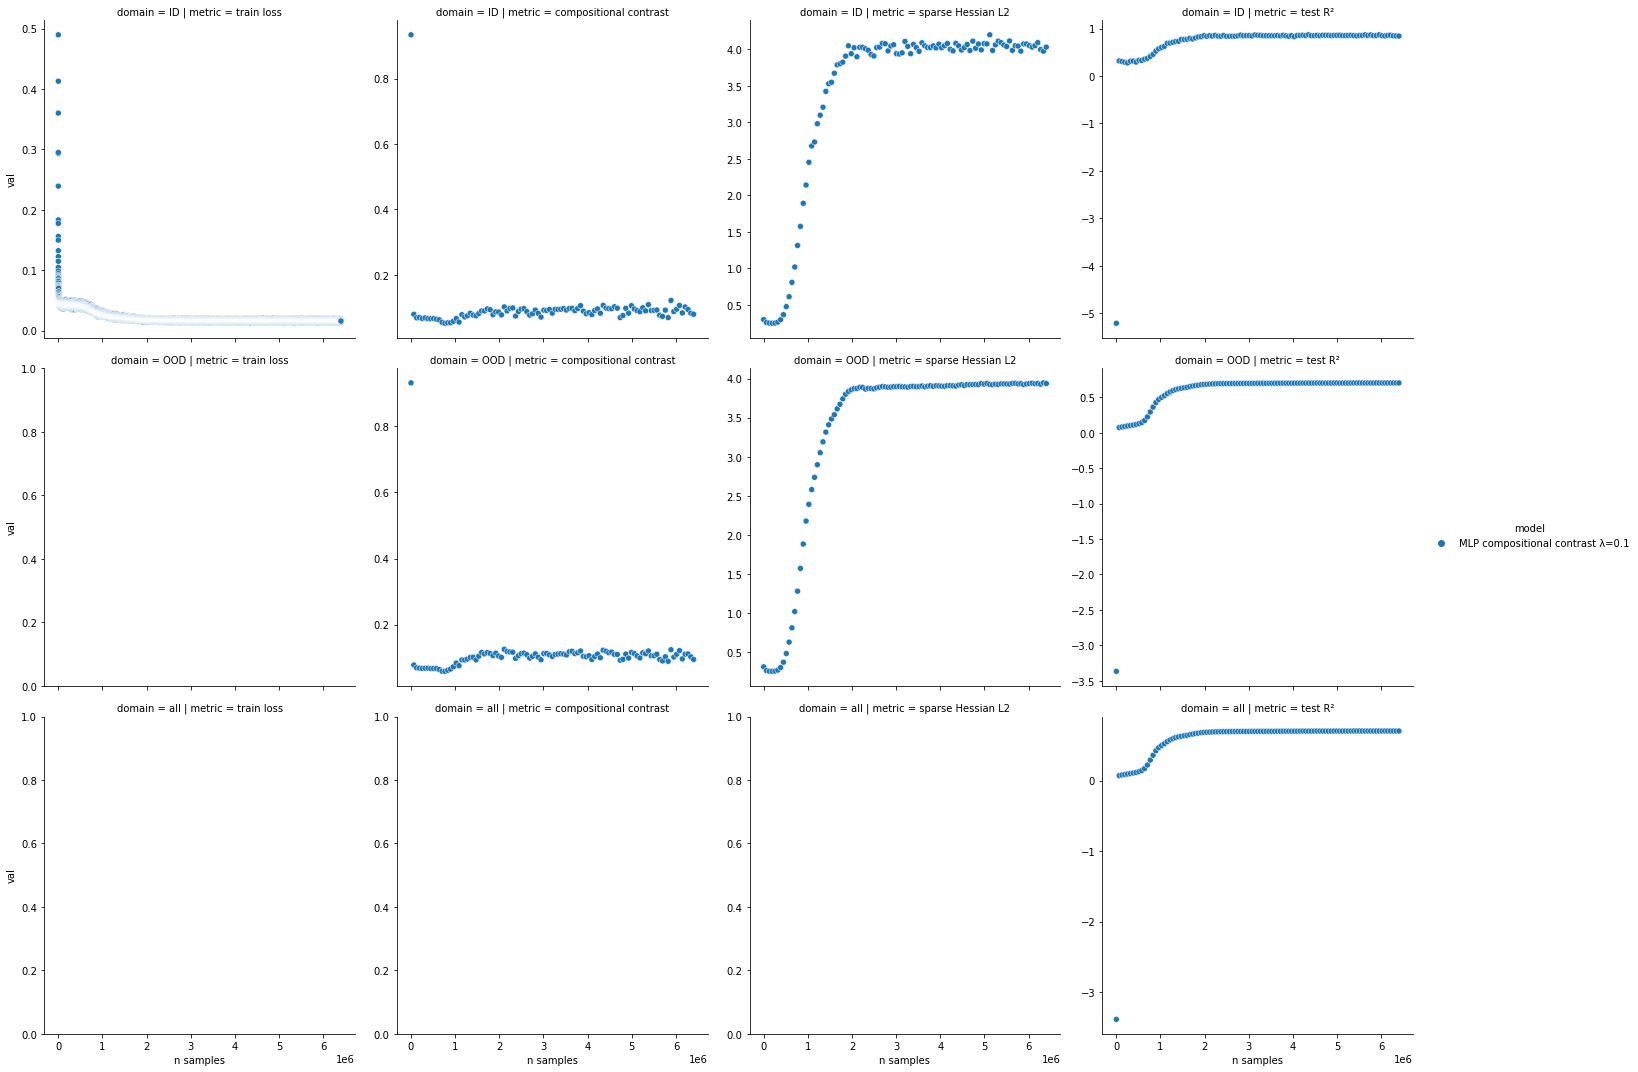

In [36]:
import seaborn as sb
fg = sb.relplot(data=res_df.loc[(res_df['n samples'] > 0)], x='n samples', y='val', hue='model', col='metric', row='domain', facet_kws={'sharey': False, 'sharex': True})

In [1]:
import pickle as pk
with open(r'res/202208111715_gs_dim_infsampl/df.pkl', 'rb') as f:
    res_gs = pk.load(f)

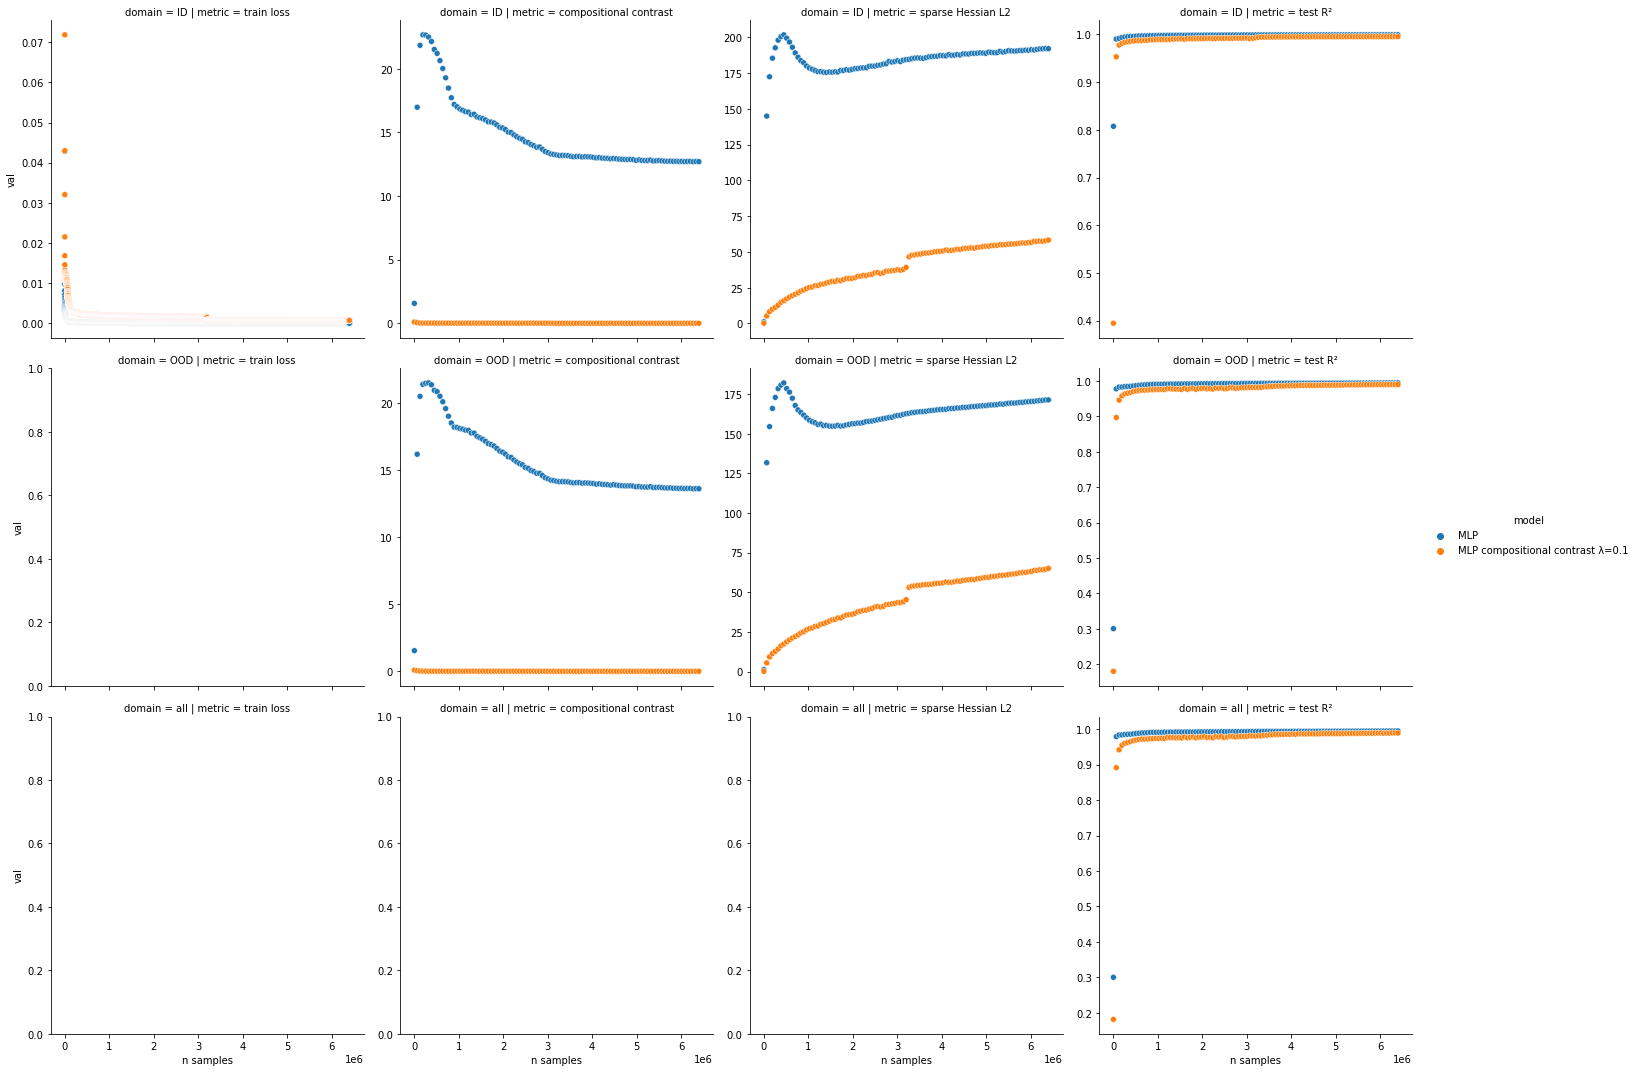

In [2]:
import seaborn as sb
fg = sb.relplot(data=res_gs.loc[(res_gs['n samples'] > 0)], x='n samples', y='val', hue='model', col='metric', row='domain', facet_kws={'sharey': False, 'sharex': True})

In [15]:
k, l, m = 4, 2, 10
mlp = MLPTanh(k, l, m).to(dev)
mlp.load_state_dict(torch.load(r'res/202208111715_gs_dim_infsampl/k4l2m10_diag02_MLP.pth'))

<All keys matched successfully>

In [11]:
g = get_generators(k, l, m)
sampling = {'str': 'diag001', 'name': 'diagonal ∆0.01', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.02}}
id_ds = Dataset(1000, k, l, g, **sampling['kwargs'])
id_ldr = torch.utils.data.DataLoader(id_ds, batch_size=1, shuffle=True)
ood_ds = OODDataset(1000, k, l, g, **sampling['kwargs'])
ood_ldr = torch.utils.data.DataLoader(ood_ds, batch_size=1, shuffle=True)

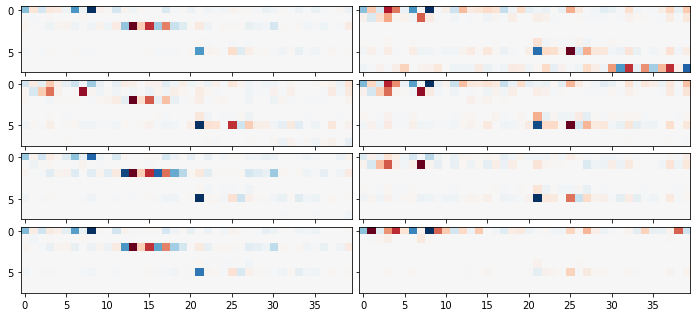

In [16]:
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12., 24.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

iter_id = id_ldr.__iter__()
iter_ood = ood_ldr.__iter__()
for i, ax in enumerate(grid):
    if i % 2 == 0:
        jac = functorch.jacrev(mlp)(iter_id.next()[0].flatten().to(dev)).detach().cpu()
    else:
        jac = functorch.jacrev(mlp)(iter_ood.next()[0].flatten().to(dev)).detach().cpu()
    ax.imshow(jac, cmap='RdBu', norm=colors.TwoSlopeNorm(0))


In [ ]:
id_ds = Dataset(1000, k, l, g, **sampling['kwargs'])
id_ldr = torch.utils.data.DataLoader(id_ds, batch_size=64, shuffle=True)

In [ ]:
iter_id = id_ldr.__iter__()
x = iter_id.next()[0].flatten(1).to(dev)

In [ ]:
# compute the jacobian with respect to the inputs
jac = functorch.vmap(functorch.jacrev(mlp))(x).transpose(1, 2)

# # compute the compositional contrast as the sum of all pairs of partial derivatives for all outputs
# # average over the batch dimension
cc = (jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1)).pow(2) * (jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1).transpose(2, 3)).pow(2)

block_diagonal = torch.block_diag(*torch.ones(4, 2, 2, dtype=bool)).to(dev)

cc = torch.where(~block_diagonal, cc, 0).triu(1).sum((2, 3)).pow(1/2).sum(1).mean()
print(cc)

cc = (jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1)).abs() * (jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1).transpose(2, 3)).abs()

block_diagonal = torch.block_diag(*torch.ones(4, 2, 2, dtype=bool)).to(dev)

cc = torch.where(~block_diagonal, cc, 0).triu(1).sum((1, 2, 3)).mean()
print(cc)

In [ ]:
cc.shape

In [ ]:
jac.unsqueeze(2).repeat(1, 1, jac.shape[2], 1).shape

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(24., 24.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(8, 8),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

iter_id = id_ldr.__iter__()
iter_ood = ood_ldr.__iter__()
for i in range(4):
    hess_id = functorch.hessian(mlp)(iter_id.next()[0].flatten().to(dev)).detach().cpu()
    hess_ood = functorch.hessian(mlp)(iter_ood.next()[0].flatten().to(dev)).detach().cpu()
    for j, _hess in enumerate(hess_id.unbind()):
        grid[i + 8*j].imshow(_hess, cmap='RdBu', norm=colors.TwoSlopeNorm(0))
    # for j, _hess in enumerate(hess_ood.unbind()):
    #     grid[i+4 + 8*j].imshow(_hess, cmap='RdBu', norm=colors.TwoSlopeNorm(0))


In [ ]:
import pickle as pk
with open(r'res/202208031841_i1000_lr1_bs4096/df.pkl', 'rb') as f:
    res_normal = pk.load(f)
with open(r'res/202208031847_i1000_lr1_bs4096/df.pkl', 'rb') as f:
    res_reged = pk.load(f)
res_df = pd.concat([res_normal, res_reged])

import seaborn as sb
fg = sb.relplot(data=res_df.loc[(res_df['metric'] == 'test R²') & (res_df['n samples'] > 500000)], x='n samples', y='val', hue='model', col='sampling', kind='line')

In [ ]:
import os
import shutil
import datetime
import pandas as pd
import pickle as pk
import seaborn as sb
from tqdm.notebook import tqdm

dirs = ['res/202208041913_i50000_lr01_bs4096', 'res/202208091450_i10000_lr01_bs4096_ft']

samplings = [
    # {'str': 'orth', 'name': 'orthogonal', 'n': 4096, 'kwargs': {'sample_mode': 'orthogonal'}},
    # {'str': 'diag', 'name': 'diagonal', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.}},
    {'str': 'diag001', 'name': 'diagonal ∆0.01', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.01}},
    # {'str': 'diag002', 'name': 'diagonal ∆0.02', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.02}},
    # {'str': 'diag005', 'name': 'diagonal ∆0.05', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.05}},
    {'str': 'diag01', 'name': 'diagonal ∆0.1', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.1}},
    {'str': 'diag02', 'name': 'diagonal ∆0.2', 'n': 4096, 'kwargs': {'sample_mode': 'diagonal', 'delta': 0.2}},
]

models = [
    {'str': 'MLP', 'name': 'MLP', 'model': MLPTanh},
    # {'str': 'MLPjac', 'name': 'MLP compositional contrast', 'model': MLPTanh, 'regularizer': comp_contrast, 'kwargs': {}},
    # {'str': 'MLPhes0', 'name': 'MLP sparse hessian L0', 'model': MLPTanh, 'regularizer': sparse_hess, 'kwargs': {'p': 0}},
    # {'str': 'MLPhes1', 'name': 'MLP sparse hessian L1', 'model': MLPTanh, 'regularizer': sparse_hess, 'kwargs': {'p': 1}},
    {'str': 'MLPhes2', 'name': 'MLP Hessian L2', 'model': MLPTanh},
    {'str': 'MLP0001hes2', 'name': 'MLP Hessian L2 0.001', 'model': MLPTanh},
]

def get_model_file(dirs, model_dict):
    for dir in dirs:
        model_file = f'{dir}/{sampling["str"]}_{model_dict["str"]}.pth'
        if os.path.exists(model_file):
            return model_file
    return None

res = []
for sampling in samplings:
    # construct ID and OOD sampler
    n = 1000
    id_ds = Dataset(n, k, l, g, **sampling['kwargs'])
    id_ldr = torch.utils.data.DataLoader(id_ds, batch_size=n, shuffle=True)

    ood_ds = OODDataset(n, k, l, g, **sampling['kwargs'])
    ood_ldr = torch.utils.data.DataLoader(ood_ds, batch_size=n, shuffle=True)

    for model in models:
        mdl = model['model'](k, l, m).to(dev)
        # try to load model
        model_file = get_model_file(dirs, model)
        if model_file is None:
            print(f'skipping missing combination {sampling["name"]} and {model["name"]}')
            continue
        mdl.load_state_dict(torch.load(model_file))

        # compute compositional contrast and Hessian sparsity on ID and OOD set
        r2 = test(mdl, te_ldr)
        r2_id = test(mdl, id_ldr)
        r2_ood = test(mdl, ood_ldr)
        jac_id = test(mdl, id_ldr, comp_contrast)
        jac_ood = test(mdl, ood_ldr, comp_contrast)
        hes0_id = test(mdl, id_ldr, sparse_hess)
        hes0_ood = test(mdl, ood_ldr, sparse_hess)
        hes1_id = test(mdl, id_ldr, sparse_hess, p=1)
        hes1_ood = test(mdl, ood_ldr, sparse_hess, p=1)
        hes2_id = test(mdl, id_ldr, sparse_hess, p=2)
        hes2_ood = test(mdl, ood_ldr, sparse_hess, p=2)

        res.append({'metric': 'R²', 'domain': 'all', 'model': model['name'], 'sampling': sampling['name'], 'val': r2})
        res.append({'metric': 'R²', 'domain': 'ID', 'model': model['name'], 'sampling': sampling['name'], 'val': r2_id})
        res.append({'metric': 'R²', 'domain': 'OOD', 'model': model['name'], 'sampling': sampling['name'], 'val': r2_ood})
        res.append({'metric': 'compositional contrast', 'domain': 'ID', 'model': model['name'], 'sampling': sampling['name'], 'val': jac_id})
        res.append({'metric': 'compositional contrast', 'domain': 'OOD', 'model': model['name'], 'sampling': sampling['name'], 'val': jac_ood})
        res.append({'metric': 'Hessian L0', 'domain': 'ID', 'model': model['name'], 'sampling': sampling['name'], 'val': hes0_id})
        res.append({'metric': 'Hessian L0', 'domain': 'OOD', 'model': model['name'], 'sampling': sampling['name'], 'val': hes0_ood})
        res.append({'metric': 'Hessian L1', 'domain': 'ID', 'model': model['name'], 'sampling': sampling['name'], 'val': hes1_id})
        res.append({'metric': 'Hessian L1', 'domain': 'OOD', 'model': model['name'], 'sampling': sampling['name'], 'val': hes1_ood})
        res.append({'metric': 'Hessian L2', 'domain': 'ID', 'model': model['name'], 'sampling': sampling['name'], 'val': hes2_id})
        res.append({'metric': 'Hessian L2', 'domain': 'OOD', 'model': model['name'], 'sampling': sampling['name'], 'val': hes2_ood})

res_df = pd.DataFrame.from_dict(res)

In [ ]:
fg = sb.catplot(data=res_df.loc[(res_df['metric'].isin(['R²']))], x='domain', y='val', hue='model', col='sampling', row='metric', kind='bar')
# sb.barplot(data=res_df.loc[(res_df['metric'] == 'compositional contrast') & (res_df['sampling'] == 'diagonal ∆0.2')], y='val', x='model', hue='domain')

In [ ]:
with open(r'res/i500_lr0001_all.pkl', 'rb') as f:
    normal = pk.load(f)
    normal = normal.loc[normal['n samples'] == 4096]
with open(r'res/i500_lr0001_all_hess.pkl', 'rb') as f:
    hess = pk.load(f)
with open(r'res/i500_lr0001_all_jac2.pkl', 'rb') as f:
    jac = pk.load(f)
    jac['model'] = jac['model'].replace({'normal': 'comp contrast'})

res_df = pd.merge(jac, hess, 'outer')
res_df = pd.merge(res_df, normal, 'outer')

In [ ]:
import seaborn as sb
fg = sb.relplot(data=res_df.loc[(res_df['metric'] == 'test R²') & (res_df['n batches'] > 100000)], x='n batches', y='val', hue='model', col='sampling', kind='line')
[_fg.set_xlabel('n batches (size 4)') for _fg in fg.axes.ravel()]
[_fg.set_ylabel('R² score') for _fg in fg.axes.ravel()]